In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandas.io.json._normalize import nested_to_record

%matplotlib inline

## gather data df

In [2]:
pull_from_wandb = False
sample_name = "data/num_train_samples"
metric_name = "test/roc_auc"
temporal_metric_name = "test/temporal_roc_auc"
loss_name = "test/loss"
temporal_loss_name = "test/temporal_loss"
pretrained_names = [
    "nyutron (ours, clinical)",
    "web-wiki+bio+clinical",
    "web-wiki+bio",
    "web-wiki",
    "random-init",
    "lace+xgb",
]

if pull_from_wandb:
    username = "lavender"
    project_name = "clinical_vs_wiki-new-fixed"
    import wandb

    api = wandb.Api()

    # Project is specified by <entity/project-name>
    runs = api.runs(f"{username}/{project_name}")
    summary_list = []
    config_list = []
    name_list = []
    for run in runs:
        # run.summary are the output key/values like accuracy.
        # We call ._json_dict to omit large files
        summary_list.append(run.summary._json_dict)

        # run.config is the input metrics.
        # We remove special values that start with _.
        conf = nested_to_record(run.config, sep="/")
        config = {k: v for k, v in conf.items() if not k.startswith("_")}
        config_list.append(config)

        # run.name is the name of the run.
        name_list.append(run.name)

    import pandas as pd

    summary_df = pd.DataFrame.from_records(summary_list)
    config_df = pd.DataFrame.from_records(config_list)
    name_df = pd.DataFrame({"name": name_list})
    data_df = pd.concat([name_df, config_df, summary_df], axis=1)

    data_df.to_csv("data/eff.csv")
else:
    data_df = pd.read_csv("./raw_data/3b_plot.csv", index_col=0)

In [3]:
data_df["pretrained"] = data_df["pretrained"].replace({"clinical": "nyutron (ours)"})

In [4]:
data_df = data_df.rename(columns={"pretrained": "pretrained LLM"})

In [5]:
data_df[["pretrained LLM", sample_name]]

,pretrained LLM,data/num_train_samples
107,"nyutron (ours, clinical)",362259
104,"nyutron (ours, clinical)",100
105,"nyutron (ours, clinical)",362259
106,"nyutron (ours, clinical)",362259
108,"nyutron (ours, clinical)",362259
...,...,...
130,lace+xgb,100000
129,lace+xgb,362259
152,lace+xgb,1000
140,lace+xgb,10000


In [6]:
def prep(df):
    df = df.rename(
        columns={
            sample_name: "Number of Train Examples",
            metric_name: "Same-time Test AUROC",
            temporal_metric_name: "Temporal Test AUROC",
            loss_name: "Same-time Test Loss",
            temporal_loss_name: "Temporal Test Loss",
        }
    )
    return df


df_plot = prep(data_df)

In [7]:
import numpy as np

np.unique(np.array(df_plot["pretrained LLM"]))

array(['lace+xgb', 'nyutron (ours, clinical)', 'random-init', 'web-wiki',
       'web-wiki+bio', 'web-wiki+bio+clinical'], dtype=object)

## Plot combined dfs

In [8]:
df_plot.columns

Index(['Number of Train Examples', 'Same-time Test AUROC',
       'Temporal Test AUROC', 'pretrained LLM', 'data_type'],
      dtype='object')

In [9]:
df_plot["pretrained LLM"] = pd.Categorical(
    df_plot["pretrained LLM"], categories=pretrained_names, ordered=True
)
df_plot = df_plot.sort_values(by="pretrained LLM")

/tmp/ipykernel_8778/262282316.py:18: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax1 = sns.lineplot(x="Number of Train Examples", y=name,
/tmp/ipykernel_8778/262282316.py:18: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax1 = sns.lineplot(x="Number of Train Examples", y=name,


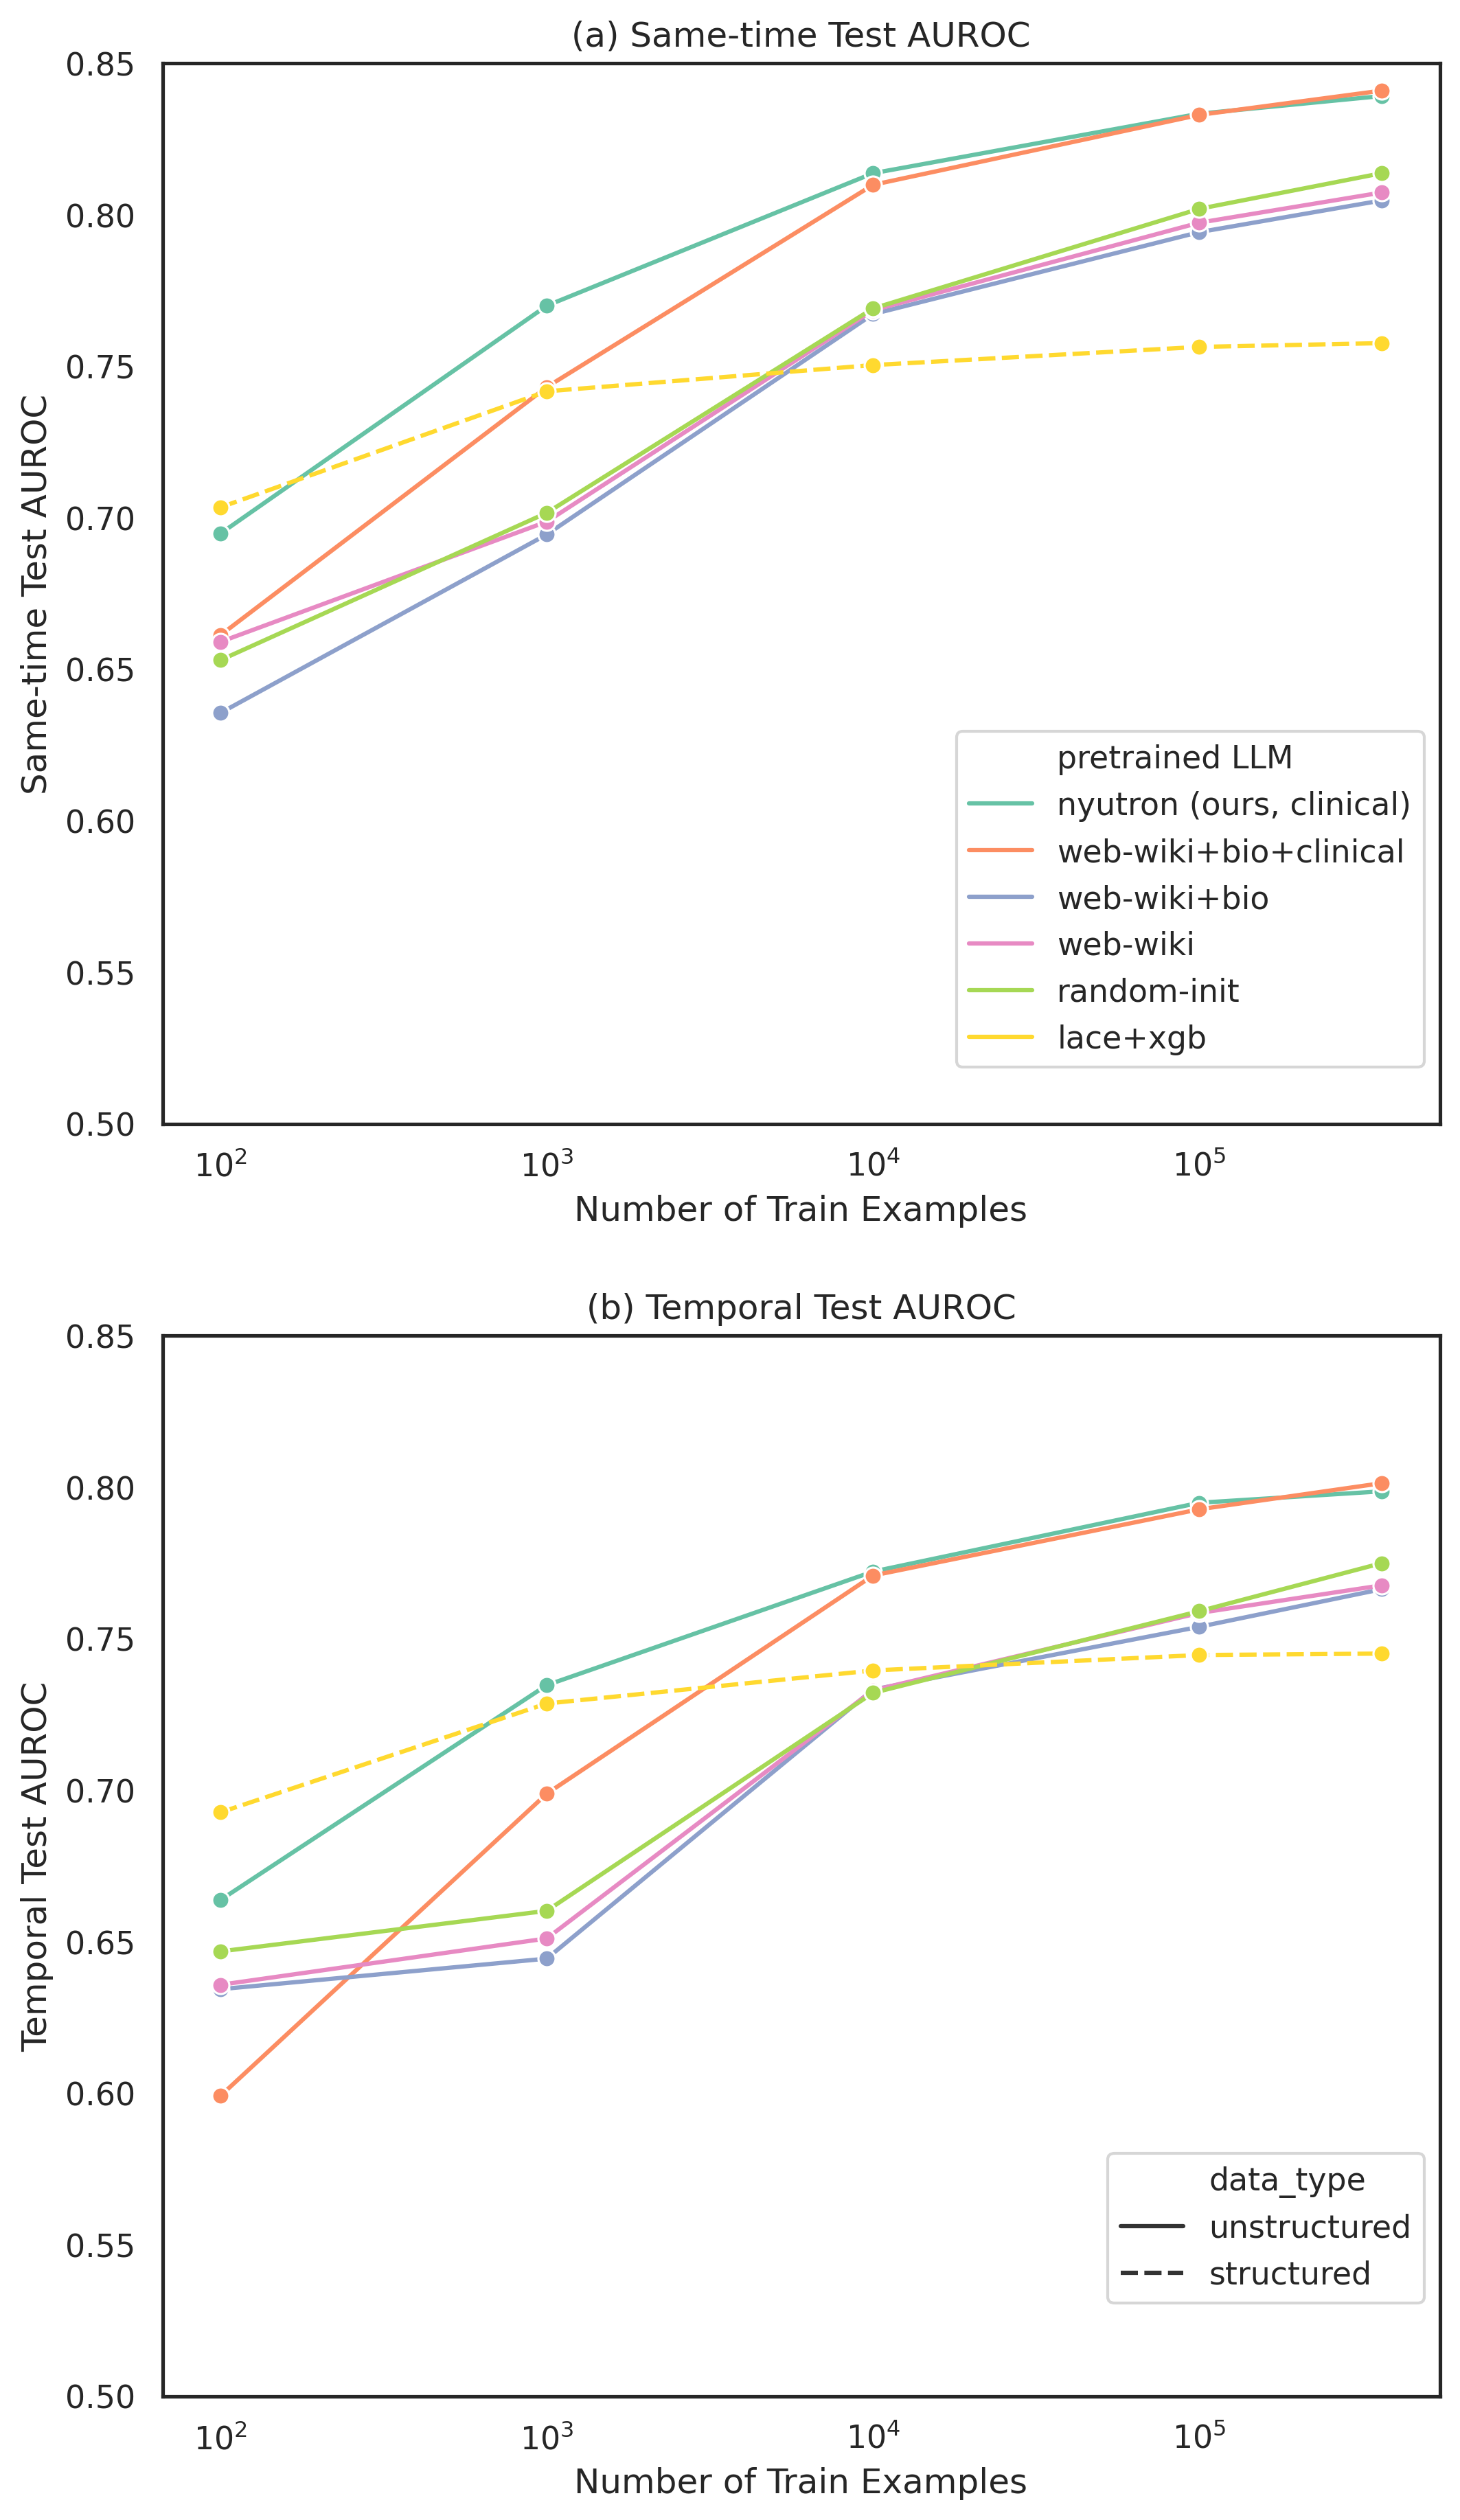

In [10]:
fig = plt.figure(figsize=(8, 15), dpi=300)
save_name = "new_data_eff.png"
sns.set(font_scale=1)
sns.set_style("white")
idx = ["a", "b"]
vals = [metric_name, temporal_metric_name]
plot_name = {
    metric_name: "Same-time Test AUROC",
    temporal_metric_name: "Temporal Test AUROC",
}
sns.color_palette("pastel")

# add subplots
handles = None
labels = None
for i, val in enumerate(vals, 1):
    name = plot_name[val]
    plt.subplot(2, 1, i)
    ax1 = sns.lineplot(
        x="Number of Train Examples",
        y=name,
        hue="pretrained LLM",
        style="data_type",
        marker="o",
        ci=None,
        estimator=np.median,
        palette=sns.color_palette("Set2", 6),
        data=df_plot,
    )
    ax1.set(xscale="log")
    if handles is None and labels is None:
        handles, labels = ax1.get_legend_handles_labels()
    ax1.get_legend().remove()
    plt.title(f"({idx[i-1]}) {name}")
    plt.ylim((0.5, 0.85))

fig.legend(
    handles[:-3], labels[:-3], loc="lower right", ncol=1, bbox_to_anchor=(0.9, 0.55)
)
fig.legend(
    handles[-3:], labels[-3:], loc="lower right", ncol=1, bbox_to_anchor=(0.9, 0.15)
)
plt.show()
fig.suptitle("Comparison of Pretrained/Random Models for Readmission Finetuning")

plt.show()
fig.savefig("plots/temporal_and_random_eff.png", dpi=300)
fig.savefig("AIP_plots/ext_4b.png", dpi=300)